# Проект на экзамен по Риск‐менеджменту 2021. Кредитный риск


### Выбор риск‐факторов 

Для начала построим матрицы миграций рейтингов.

**Методология: Матрицы переходных вероятностей**


1.   Класс рассматривает рейтинг каждой компании с промежутком в год:
    * В случае, если не происходит присвоения нового рейтинга - актуальным
    считается старый
    * Промежуточные изменения рейтинга между двумя отсечками не учитываются
    * Переходы в рейтинг NR без дальнейшей информации не учитываются в
    количестве рейтингов на начало периода
    * Переходы в NR с возможных дефолтом после учитываются




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings("ignore")

class RatingChanges():
    def __init__(self, df, rating_letter = "A"):
        self.df = df
        self.df["Дополнительная информация"].fillna("", inplace = True)
        # Заменяем "После отзыва дефолт можно наблюдать" на метку _D
        self.df["Дополнительная информация"] = self.df["Дополнительная информация"].replace({"После отзыва дефолт можно наблюдать":
                                                                           "_D"})
        # После суммирования получаем два типа NR - NR с возможным дефолтом (NR_D) и ненаблюдаемый NR (NR)
        self.df["Рейтинг"] = self.df["Рейтинг"] + self.df["Дополнительная информация"] 
        self.df = self.df.drop(columns = ["Дополнительная информация"])
        # Создаем плейсхолдер для последующего джойна (в нем содержатся только индексы заемщмиков)
        self.df_for_join = self.df.drop(columns = ["Дата", "Рейтинг"]).drop_duplicates().set_index("Заемщик")
        self.rating_letter = rating_letter
    

    def find_current_rating(self, date):
        # выбирает последнее наблюдение за период
        self.current_ratings = self.df[self.df.Дата < date].groupby("Заемщик").tail(1) 
        return self.current_ratings

    # Создает датасет с рейтингами на каждый год для заемщиков    
    def create_rating_dataframe(self):
        start_date = self.df.Дата.min()
        for i in range(1, 1827, 365):
            # С промежутком в год проверяем смену рейтинга, при отсутствии новой информации берется последний рейтинг
            # Увеличение даты на 365 на новой итерации
            current_date = start_date + pd.to_timedelta(i, unit = "D")
            # Поиск последнего рейтинга
            ratings = self.find_current_rating(current_date)
            # Для создания матрицы меняются буквы на цифры
            ratings["Рейтинг"] = ratings["Рейтинг"].str.replace(self.rating_letter, "")
            ratings["Рейтинг"] = ratings["Рейтинг"].str.replace("NR_D", "9")
            ratings["Рейтинг"] = ratings["Рейтинг"].str.replace("D", "10")
            ratings["Рейтинг"] = ratings["Рейтинг"].str.replace("NR", "11")
            # Присоединение рейтингов к заемщикам, df_for_join состоит из одной колонки "Заемщик", 
            # Нужно, так как не все заемщики есть в данных с первого периода
            self.df_for_join = self.df_for_join.join(ratings.drop(columns = "Дата").set_index("Заемщик"), 
                                                     rsuffix = "_" + str(current_date))
        return self.df_for_join

    def get_changes_matr(self):
        self.changes_matr_cumul = np.zeros((11, 11))
        self.pd_matrix = np.zeros((5, 8)) # pd for each year, by rating
        self.changes_matrix_placeholder = np.zeros((5, 11, 11))
        for i in range(0, 5):
            # Берутся две соседние колонки
            year_horizon = self.df_for_join.iloc[:, i:i+2].dropna()
            year_horizon.columns = ["t", "t + 1"]
            # Подсчет количества заемщиков в категориях (1, 1); (1, 2); ...
            changes = year_horizon.groupby(["t", "t + 1"]).size()
            changes_matrix = np.zeros((11, 11))
            for j, index_ in enumerate(changes.index):
                index_ = list(map(int, index_))
                # Индекс снижается на 1 для того, что начинался с 0
                index_ = list(map(lambda index: index - 1, index_))
                # Присваеваем элементам матрицы с индексом (0, 0), ... количества переходов из 0 в 0, и т.д.
                changes_matrix[index_[0], index_[1]] =  changes.iloc[j]
            # 3х мерная матрица с переходами для каждого года
            self.changes_matrix_placeholder[i, :, :] = changes_matrix
            # Накапливается за несколько операций
            self.changes_matr_cumul += changes_matrix
            # PD для каждого рейтинга за один год
            pd_vector = changes_matrix[:-3, -2]/changes_matrix[:-3].sum(axis = 1)
            self.pd_matrix[i, :] = pd_vector
        self.changes_df = pd.DataFrame(self.changes_matr_cumul)
        # лямбда функция меняет A на ту букву, которая используется в конкретном рейтинге (для красоты)
        rating_names = list(map(lambda rating_name: rating_name.replace("A", self.rating_letter),
                                ["A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "NR_D", "D", "NR"]))
        self.changes_df.columns = rating_names
        self.changes_df.index = rating_names
        return self.changes_df

In [ ]:
# for A rating
df = pd.read_excel("data 1.xlsx")
rating_class_A = RatingChanges(df)
rating_class_A.create_rating_dataframe()
rating_class_A.get_changes_matr()

,A1,A2,A3,A4,A5,A6,A7,A8,NR_D,D,NR
A1,161.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0
A2,1.0,225.0,4.0,4.0,0.0,0.0,0.0,0.0,7.0,7.0,7.0
A3,2.0,9.0,174.0,3.0,2.0,0.0,0.0,0.0,5.0,4.0,10.0
A4,0.0,0.0,5.0,135.0,4.0,1.0,3.0,1.0,8.0,6.0,1.0
A5,0.0,0.0,0.0,7.0,114.0,6.0,3.0,2.0,5.0,8.0,1.0
A6,0.0,0.0,0.0,0.0,2.0,63.0,5.0,1.0,3.0,18.0,3.0
A7,0.0,0.0,0.0,0.0,0.0,2.0,25.0,1.0,2.0,22.0,3.0
A8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,13.0,0.0
NR_D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,8.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,212.0,0.0


У модели А крайне редко происходят повышения рейтинга более чем на одну группу выше. Такие случаи происходили только два раза за 5 лет. Чуть менее редко происходят повышения рейтингов. Чаще всего миграция компании происходит сразу непосредственно в дефолтную группу. В целом данная модель показывает относительно низкую мобильность компаний за 5 лет.

In [ ]:
# for I rating
df = pd.read_excel("data 1.xlsx", sheet_name = 1)
rating_class_I = RatingChanges(df, rating_letter = "I")
rating_class_I.create_rating_dataframe()
rating_class_I.get_changes_matr()

,I1,I2,I3,I4,I5,I6,I7,I8,NR_D,D,NR
I1,161.0,6.0,10.0,5.0,2.0,1.0,2.0,1.0,5.0,1.0,3.0
I2,9.0,194.0,7.0,3.0,10.0,11.0,0.0,2.0,3.0,5.0,3.0
I3,5.0,11.0,154.0,7.0,6.0,2.0,6.0,1.0,3.0,12.0,5.0
I4,1.0,6.0,8.0,87.0,8.0,2.0,1.0,1.0,5.0,8.0,11.0
I5,0.0,3.0,7.0,7.0,95.0,7.0,8.0,1.0,4.0,11.0,4.0
I6,0.0,1.0,0.0,2.0,5.0,49.0,5.0,2.0,3.0,18.0,6.0
I7,0.0,0.0,0.0,0.0,1.0,5.0,29.0,4.0,1.0,20.0,1.0
I8,0.0,0.0,0.0,0.0,0.0,0.0,4.0,9.0,1.0,10.0,0.0
NR_D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,2.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232.0,0.0


Модель I демонстрирует более высокую мобильность компаний внутри рейтингов. У компаний чаще понижаются рейтинги.

In [ ]:
# for B rating
df = pd.read_excel("data 1.xlsx", sheet_name = 2)
rating_class_B = RatingChanges(df, rating_letter = "B")
rating_class_B.create_rating_dataframe()
rating_class_B.get_changes_matr()

,B1,B2,B3,B4,B5,B6,B7,B8,NR_D,D,NR
B1,159.0,3.0,10.0,3.0,4.0,1.0,2.0,0.0,2.0,1.0,4.0
B2,6.0,148.0,8.0,3.0,1.0,4.0,0.0,2.0,5.0,9.0,3.0
B3,2.0,7.0,161.0,12.0,1.0,2.0,1.0,2.0,4.0,18.0,9.0
B4,1.0,4.0,7.0,117.0,9.0,2.0,2.0,1.0,8.0,9.0,6.0
B5,0.0,3.0,4.0,4.0,78.0,12.0,6.0,1.0,9.0,9.0,7.0
B6,0.0,2.0,2.0,4.0,10.0,79.0,8.0,1.0,8.0,5.0,6.0
B7,0.0,0.0,0.0,0.0,1.0,11.0,46.0,8.0,4.0,9.0,4.0
B8,0.0,0.0,0.0,0.0,0.0,3.0,7.0,14.0,2.0,7.0,3.0
NR_D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,6.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,155.0,0.0


В данной модели также наблюдается миграция выше чем в первой. Также чаще происходит миграция в более высокие рейтинги чем в первых двух моделях.
Таким образом, модель А предполагает большую стабильность, а в моделях B и I более заметна мобильность. 

Формулы расчета Default Rate, AUC и Accuracy Ratio:


$$AUC_{CAP} = 0.5\sum\limits_{i=0,..,k-1}(TPR_{i+1} + TPR_i)(PPR_{i+1} -PPR_i)$$
$$DR = \frac{\sum_i{D_i}}{\sum_i{N_i}}$$
$$ AR_{CAP} = \frac{AUC - 0.5}{AUC(PerfectCAP) -0.5} =  \frac{AUC - 0.5}{0.5(1- DR)} = \frac{2AUC - 1}{1- DR}$$

In [ ]:
class Description:
      def __init__(self, rating_class_A, rating_class_B, rating_class_I, year=None):
          self.year = year
          # Достаем общую матрицу переходов, либо за конкретный год 
          if self.year != None:
            self.cm_A = rating_class_A.changes_matrix_placeholder[self.year]
            self.cm_B = rating_class_B.changes_matrix_placeholder[self.year]
            self.cm_I = rating_class_I.changes_matrix_placeholder[self.year]
          else:
            self.cm_A = rating_class_A.changes_matr_cumul
            self.cm_B = rating_class_B.changes_matr_cumul
            self.cm_I = rating_class_I.changes_matr_cumul

      def cap_data(self, N, D):
          # Расчет Population Positive Rate и True Positive Rate 
          N, D = np.insert(N, 0, 0), np.insert(D, 0, 0)
          ppr, tpr = N.cumsum()/N.sum(), D.cumsum()/D.sum()
          return ppr, tpr 
      
      def pds(self):
          # Находим PD для каждого рейтинга -- Число дефолтов деленное на число переходов
          self.pds_A = self.cm_A[:-3, -2]/self.cm_A[:-3].sum(axis = 1) 
          self.pds_B = self.cm_B[:-3, -2]/self.cm_B[:-3].sum(axis = 1)
          self.pds_I = self.cm_I[:-3, -2]/self.cm_I[:-3].sum(axis = 1)
          return self.pds_A, self.pds_B, self.pds_I

      def cap_curves(self):
          # Находим ppr и tpr по формулам из cap_data
          self.emp_ppr_A, self.emp_tpr_A = self.cap_data(self.cm_A[:-3].sum(axis = 1)[::-1], self.cm_A[:-3, -2][::-1])
          self.emp_ppr_B, self.emp_tpr_B = self.cap_data(self.cm_B[:-3].sum(axis = 1)[::-1], self.cm_B[:-3, -2][::-1])
          self.emp_ppr_I, self.emp_tpr_I = self.cap_data(self.cm_I[:-3].sum(axis = 1)[::-1], self.cm_I[:-3, -2][::-1])
          
        
      def auc_ar(self):
          # Находим Default Rate, AUC и Accuracy Ratio по формулам выше
          dr_A = self.cm_A[:-3, -2].sum()/self.cm_A[:-3].sum(axis = 1).sum()
          auc_A = 0.5 * (self.emp_tpr_A[1:] + self.emp_tpr_A[:-1])@(self.emp_ppr_A[1:] - self.emp_ppr_A[:-1])
          ar_A = (2*auc_A - 1)/(1 - self.cm_A[:-3, -2].sum()/self.cm_A[:-3].sum(axis = 1).sum())

          dr_I = self.cm_I[:-3, -2].sum()/self.cm_I[:-3].sum(axis = 1).sum()
          auc_I = 0.5 * (self.emp_tpr_I[1:] + self.emp_tpr_I[:-1])@(self.emp_ppr_I[1:] - self.emp_ppr_I[:-1])
          ar_I = (2*auc_I - 1)/(1 - self.cm_I[:-3, -2].sum()/self.cm_I[:-3].sum(axis = 1).sum())

          dr_B = self.cm_B[:-3, -2].sum()/self.cm_B[:-3].sum(axis = 1).sum()
          auc_B = 0.5 * (self.emp_tpr_B[1:] + self.emp_tpr_B[:-1])@(self.emp_ppr_B[1:] - self.emp_ppr_B[:-1])
          ar_B = (2*auc_B - 1)/(1 - self.cm_B[:-3, -2].sum()/self.cm_B[:-3].sum(axis = 1).sum())

          if self.year != None:
            return (dr_A, dr_I, dr_B, auc_A, auc_I, auc_B, ar_A, ar_I, ar_B)

          else:
            print( 'A: \n DR = {:.2%}, AUC = {:.3f}, AR = {:.2%}\n'.format(dr_A, auc_A, ar_A))
            print( 'B: \n DR = {:.2%}, AUC = {:.3f}, AR = {:.2%}\n'.format(dr_B, auc_B, ar_B))
            print( 'I: \n DR = {:.2%}, AUC = {:.3f}, AR = {:.2%}\n'.format(dr_I, auc_I, ar_I))

In [ ]:
descr = Description(rating_class_A, rating_class_B, rating_class_I)
pds_A, pds_B, pds_I = descr.pds()
descr.cap_curves()
descr.auc_ar()

A: 
 DR = 7.25%, AUC = 0.791, AR = 62.70%

B: 
 DR = 5.88%, AUC = 0.618, AR = 25.11%

I: 
 DR = 7.61%, AUC = 0.776, AR = 59.80%



Дискриминационные способности моделей можно сравнивать показателем AR даже на разных выборках. Самое высокое значение AR у модели А, что делает ее самой точной. На втором месте по точности находится модель I, отставая на 3 п.п. Отметим, что доли дефолтов в моделях A и I отличаются лишь на 0.4 п.п., то есть их можно грубо сравнить по CAP-кривым.

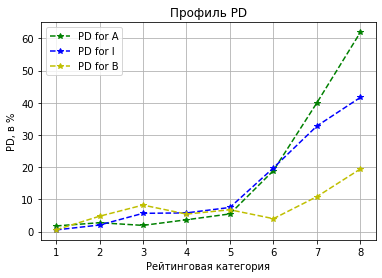

In [ ]:
grades = [i+1 for i in range(8)]
plt.plot(grades, 100 * descr.pds_A, '--*g', label = "PD for A")
plt.plot(grades, 100 * descr.pds_I, '--*b', label = "PD for I")
plt.plot(grades, 100 * descr.pds_B, '--*y', label = "PD for B")
plt.title('Профиль PD')
plt.ylabel('PD, в %')
plt.xlabel("Рейтинговая категория")
plt.grid() 
plt.legend()
plt.show()
print('\n')

У моделей A и I веротность дефолтов за год стабильно повышается с понижением рейтинга. У модели B данная вереятность не имеет видимой связи с рейтингом, что говорит о плохом качестве рейтинга. Кроме того, критерием для отбора категории рейтинга является PD не выше 6%, для того чтобы не включать высокорискованных заемщиков. Таким образом, для модели А приемлемыми рейтингами по данному критерию являются рейтинги А1-А5, для модели I - рейтинги I1-I4, для модели В это рейтинги В1-В2.

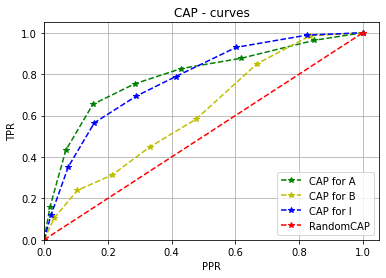

In [ ]:
plt.title('CAP - curves')
plt.grid()
plt.plot(descr.emp_ppr_A, descr.emp_tpr_A, '--*g', label = 'CAP for A')
plt.plot(descr.emp_ppr_B, descr.emp_tpr_B, '--*y', label = 'CAP for B')
plt.plot(descr.emp_ppr_I, descr.emp_tpr_I, '--*b', label = 'CAP for I')
plt.plot([0, 1], [0, 1], '--*r', label = 'RandomCAP')
plt.xlim([0,1.05]), plt.xlabel('PPR'), plt.ylabel('TPR')
plt.ylim([0,1.05])
plt.legend()
plt.show()

Модель В показывает самую низкую способность распределения рейтингов в зависимости от дефолтов, так как CAP-кривая очень близка к случайной. CAP-кривые моделей А и I близки друг к другу, однако они лучше подходят для заемщиков разного типа. Модель А лучше определяет дефолтеров среди плохих заемщиков, в то время как модель I лучше отделяет самых лучших заемщиков. 
Модели А и I показывают достаточно хорошее качество определения рейтингов, но решают немного разные задачи. Их применение может зависить, например, от желания работать с самыми лучшими заемщиками, тогда выгоднее использовать модель I. С другой стороны, если в выборке много рискованных заемщиков и вероятных дефолтеров, лучше должна справится модель I.

In [ ]:
statistics = []
for y in range(5):
  descr = Description(rating_class_A, rating_class_B, rating_class_I, year=y)
  descr.cap_curves()
  statistics.append(descr.auc_ar())
statistics = pd.DataFrame(np.array(statistics).reshape((5, 9)))
statistics.columns = ['dr_A', 'dr_I', 'dr_B', 'auc_A', 'auc_I', 'auc_B', 'ar_A', 'ar_I', 'ar_B']
statistics.index = ['2010','2011','2012','2013','2014']
statistics.round(3)

,dr_A,dr_I,dr_B,auc_A,auc_I,auc_B,ar_A,ar_I,ar_B
2010,0.125,0.175,0.060,0.789,0.736,0.579,0.661,0.571,0.168
2011,0.077,0.070,0.075,0.707,0.820,0.709,0.449,0.689,0.453
2012,0.057,0.051,0.066,0.711,0.717,0.545,0.447,0.457,0.097
2013,0.072,0.052,0.066,0.847,0.792,0.594,0.748,0.616,0.201
2014,0.039,0.047,0.026,0.804,0.691,0.710,0.632,0.400,0.430


Модель В показывает неприемлимо низкое качество показателя AR каждый год. Модели А и I тоже показывают низкие значения AR в двух годах: для первой модели это 2011 и 2012 года, для второй - 2012 и 2014. Тем не менее за долгий период времени качество моделей хорошее. 
Кроме того, каждый год доля дефолтеров в двух выборках достаточно близко, чтобы можно было их грубо сравнить на графике CAP-кривых.

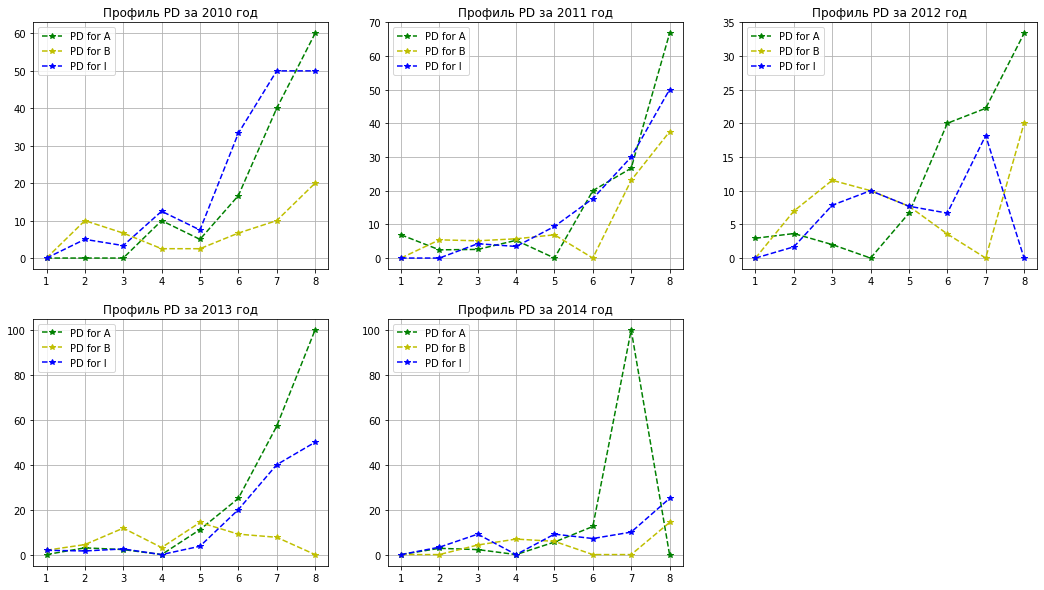

In [ ]:
plt.figure(figsize=(18, 10))
for y in range(5):
  descr = Description(rating_class_A, rating_class_B, rating_class_I, year=y)
  descr.pds()
  plt.subplot(2, 3, y+1)
  plt.plot(grades, 100 * descr.pds_A, '--*g', label = 'PD for A')
  plt.plot(grades, 100 * descr.pds_B, '--*y', label = 'PD for B')
  plt.plot(grades, 100 * descr.pds_I, '--*b', label = 'PD for I')
  plt.title(f"Профиль PD за 201{y} год")
  plt.grid() 
  plt.legend()
plt.show()

На ежегодних графиках PD модель В так же не соответствует нормальному распределению дефолтов в рейтингах. Модели A и I становятся менее стабильными на более коротких промежутках времени. Например, в 2012 году у модели I практически отсутствует связь рейтингов и вероятности дефолта. То же происходит с моделью А в 2014 году.

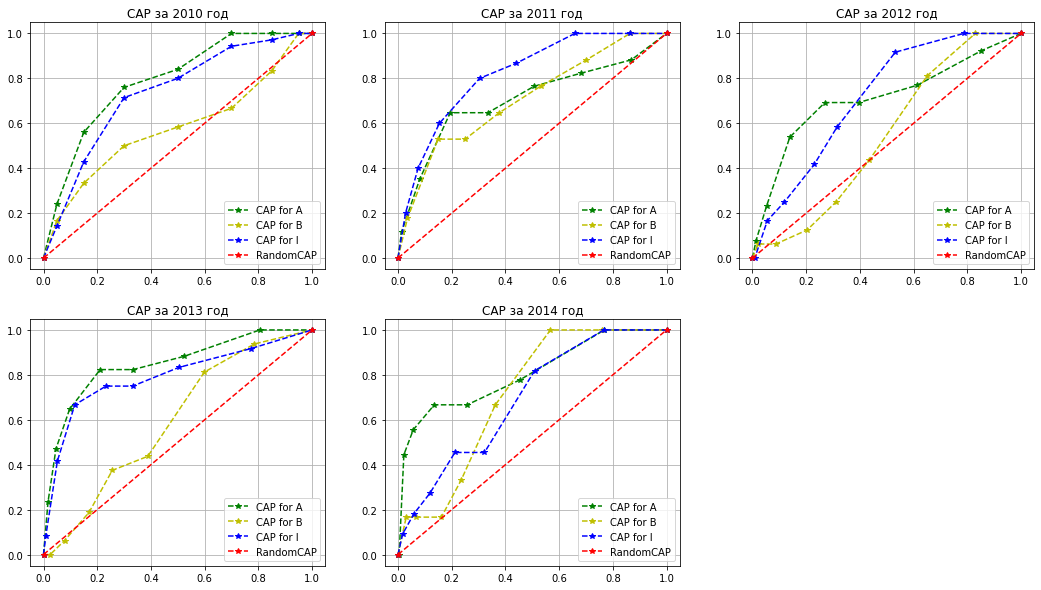

In [ ]:
plt.figure(figsize=(18, 10))
for y in range(5):
  descr = Description(rating_class_A, rating_class_B, rating_class_I, year=y)
  descr.cap_curves()
  plt.subplot(2, 3, y+1)
  plt.plot(descr.emp_ppr_A, descr.emp_tpr_A, '--*g', label = 'CAP for A')
  plt.plot(descr.emp_ppr_B, descr.emp_tpr_B, '--*y', label = 'CAP for B')
  plt.plot(descr.emp_ppr_I, descr.emp_tpr_I, '--*b', label = 'CAP for I')
  plt.plot([0, 1], [0, 1], '--*r', label = 'RandomCAP')
  plt.title(f"CAP за 201{y} год")
  plt.grid() 
  plt.legend(loc='lower right')
plt.show()

Модель В показывает качество ниже бенчмарка в 3 из 5 годах, что делает ее неприменимой. Модель А в каждый год работает лучше на плохих заемщиках каждый год, в то время как модель I не показывает постоянных результатов. В 2013 году модель I очень хорошо предсказывает плохих заемщиков, в 2012 и 2014 годах - лучше определяет хороших, в 2010 и 2011 - обе группы определяются одинаково. Таким образом, модель А более постоянна и всегда ясно, что от нее ожидать.

### Отбор заемщиков и анализ портфелей

Выбираем рейтинг A и I

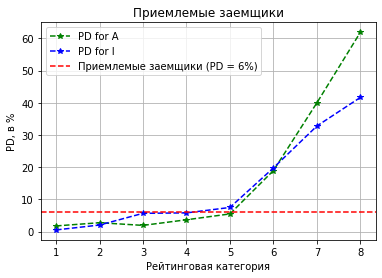

In [ ]:
plt.plot(grades, 100 * pds_A, '--*g', label = "PD for A")
plt.plot(grades, 100 * pds_I, '--*b', label = "PD for I")
plt.axhline(y = 6, linestyle = "dashed", label = "Приемлемые заемщики (PD = 6%)", color = "red")
plt.title('Приемлемые заемщики')
plt.ylabel('PD, в %')
plt.xlabel("Рейтинговая категория")
plt.grid() 
plt.legend()
plt.show()

Для дальнейших шагов выберем следующие группы заемщиков: A1-A5, I1-I4, так как для данных групп вероятность дефолта ниже 6%.

In [ ]:
df = pd.read_excel("data 1.xlsx", sheet_name = 3)

In [ ]:
df.head()

,Клиент,Амортизация,"Срок, лет",Объем,"Процентная ставка, %","Частота выплат, месяцев",Рейтинг 1,Рейтинг 2,Рейтинг 3
0,0,True,3,1050974,6.47,3,A8,B2,I8
1,1,True,3,86833,2.95,1,A5,B6,I3
2,2,False,5,1438492,4.51,12,A3,B5,I2
3,3,False,4,1469169,4.30,1,A3,B3,I4
4,4,True,2,630597,4.33,6,A4,B4,I4


In [ ]:
df = df.drop(columns = ["Рейтинг 2"])

In [ ]:
A_names = ["A{}".format(i) for i in range(1, 9)]
I_names = ["I{}".format(i) for i in range(1, 9)]
prob_dict_A = dict(zip(A_names, pds_A))
prob_dict_I = dict(zip(I_names, pds_I))

# Соотносим рейтинг для каждого заемщика с вероятностью дефолта для этого рейтинга
def get_prob_from_name(name, prob_dict):
    return prob_dict[name]

In [ ]:
df["Вероятность A"] = df["Рейтинг 1"].apply(lambda x: get_prob_from_name(x, prob_dict_A))
df["Вероятность I"] = df["Рейтинг 3"].apply(lambda x: get_prob_from_name(x, prob_dict_I))

In [ ]:
df.head()

,Клиент,Амортизация,"Срок, лет",Объем,"Процентная ставка, %","Частота выплат, месяцев",Рейтинг 1,Рейтинг 3,Вероятность A,Вероятность I
0,0,True,3,1050974,6.47,3,A8,I8,0.619048,0.416667
1,1,True,3,86833,2.95,1,A5,I3,0.054795,0.056604
2,2,False,5,1438492,4.51,12,A3,I2,0.019139,0.020243
3,3,False,4,1469169,4.30,1,A3,I4,0.019139,0.057971
4,4,True,2,630597,4.33,6,A4,I4,0.036585,0.057971


In [ ]:
# На первом этапе отсеиваем заемщиков с безусловной вероятностью дефолта > 0.06
df_filtered_A = df[(df["Вероятность A"] <= 0.06)]
df_filtered_I = df[(df["Вероятность I"]) <= 0.06]

**Методология: Интерполяция PD**

1. Существует матрица маржинальных вероятностей, посчитанная из МПВ
2. В матрицу маржинальных вероятностей добавляется слева столбец нулей, чтобы на момент времени 0 вероятность дефолта была равна 0
3. Рассчитываются форвардные вероятности $P(\tau = t_i| \tau >t_{i-1}) = (P_{t} - P_{t - 1}) / (1 - P_{t - 1})$
4. Хазардная функция рассчитывается по формуле $\lambda_t = -log(1 - P_{forward, t})$ 
5. Непрерывная форвардная вероятность рассчитывается по формуле *кусочно-постоянной функции* $P(\tau = t_i| \tau >t_{i-1}) = 1 - e^{-\sum_{i} \lambda_i (t_i - t_{i-1})}$

In [ ]:
# Имеем маржинальные вероятности для каждого года
class interpolate_PD_cum:
    def __init__(self, pd_matrix_marginal):
        self.pd_matrix_marginal = pd_matrix_marginal

    def find_pd_cum(self):
        # Переходим к кумулятивной вероятности для рассмотренного периода
        self.PD_matrix = np.minimum(np.cumsum(self.pd_matrix_marginal, axis = 0), 1)
    
    def find_hzrd_func(self):
        # Добавляем в матрицу слева столбец нулей, тк матрица вероятностей должна начинаться с 0
        PD_matrix_shifted = np.pad(self.PD_matrix, ((1, 0), (0, 0)), mode = "constant", constant_values = (0, 0)) # Чтобы PD начинался с 0
        # Считаем форвардную вероятность
        fwd_pd = (PD_matrix_shifted[1:, :] - PD_matrix_shifted[:-1, :]) / (1 - PD_matrix_shifted[:-1, :] + 1e-10)
        self.hzr_imp = -np.log(1 - fwd_pd)

    def find_probability(self, term, rating):
        # Поиск вероятности по кусочно-постоянной функции
        lamda = 0
        hzr_imp_rating = self.hzr_imp[:, rating] # Выбираем нужный рейтинг по индексу
        full_years = term // 365 # Количество полных лет для накопления полных лямбд
        for i in range(full_years):
            lamda += hzr_imp_rating[i] # Накапливаем лямбды за предыдущие годы
        terms = (term % 365) / 365 # Считаем % от года, который выступает в качестве доли накопленной за последний период лямбды
        lamda += hzr_imp_rating[full_years] * terms # Добавляем частично накопленную лямбду
        # Возвращаем вероятность, 
        # max(): тк из-за прибавления 1e-10 выше появляются предельно малые отрицательные вероятности
        return max(1 - np.exp(- lamda), 0)

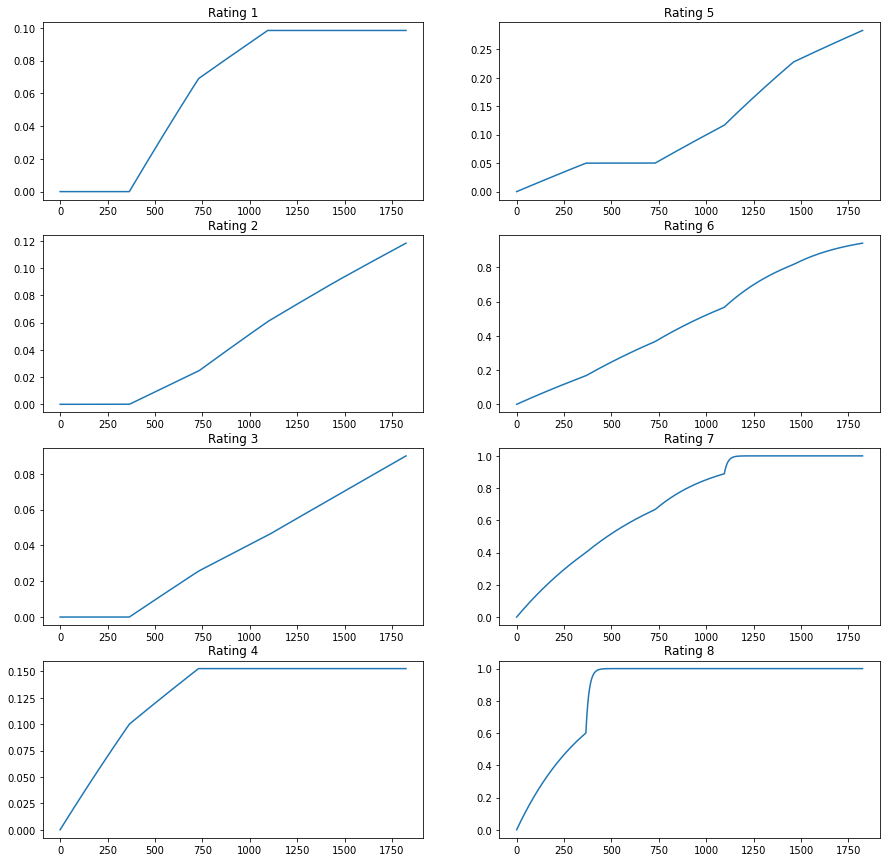

In [ ]:
import matplotlib.pyplot as plt
# Тестовое построение вероятностей для всех рейтингов и 5 лет
pd_matrix_marginal = rating_class_A.pd_matrix
pd_class = interpolate_PD_cum(pd_matrix_marginal)
pd_class.find_pd_cum()
pd_class.find_hzrd_func()
fig, ax = plt.subplots(4, 2, figsize = (15, 15))
# Перебор по рейтингу
for j in range(0, 8):
    probs_list = []
    dates_list = []
    # Перебор по дате
    for i in range(0, 365 * 5):
        probs = pd_class.find_probability(i, j)
        probs_list.append(probs)
        dates_list.append(i)
    ax[j % 4, j // 4].plot(np.array(dates_list), np.array(probs_list))
    ax[j % 4, j // 4].set_title("Rating {}".format(j + 1))
plt.show()

Графики выше показывают интерполированные вероятности дефолтов. Данный этап необходим для проверки правильности алгоритма. Вероятности дефолта в зависимости от времени, отображенные на графиках, не противоречивы.

**Методология: EAD**

1. Для амортизируемых кредитов
    * Рассчитывается платеж, как объем кредита / количество платежей
    * В каждом периоде происходит снижение объема кредита на постоянный платеж
    и выплата процентов
2. Для неамортизируемых кредитов
    * На протяжении срока кредита происходит выплата процентов, в последнем
    периоде выплачивается объем долга

In [ ]:
# Тестовая функция для построения графиков EAD
def EAD_test(volume, interest, term, frequency, amortization):
    schedule = np.array(range(0, (term)* 365, 30 * frequency))
    data = pd.DataFrame(np.nan, index = schedule, columns = ['terms', 'due', 'interest',  'EAD'])
    terms = np.zeros(len(schedule))
    terms[1:] = (schedule[1:] - schedule[:-1])/360 # Из-за 30 дневного месяца получаем 360 дней
    if amortization:
        number_of_payments = int(term * 12 / frequency) # Рассчитываем количество выплат
        main_payment = volume / number_of_payments # Размер выплаты = объем / количество
        payments_by_number = np.maximum(np.array(range(-1, number_of_payments)), 0) # Порядковый номер выплаты 
        debt = volume - main_payment * payments_by_number # Кумулятивно накапливаем выплаты за счет умножения на порядковый номер
        interest_payment = np.zeros(len(debt)) 
        interest_payment = debt * (interest / 100) * terms
        EAD = debt + interest_payment
        data["terms"] = terms
        data["due"] = debt
        data["interest"] = interest_payment
        data["EAD"] = EAD
        time_plt = np.repeat(data.index, 2)[1:] # дублируем даты, чтобы увидеть скачки EAD
        EAD_plt = np.repeat(data.EAD, 2)[1:] # локальных максимумов EAD достигает в дни уплаты процента, т.е. когда сумма накопленного процента максимальна
        EAD_plt[0:-1:2] = data.due[1:] # после очередной выплаты процента EAD падает до оставшейся суммы основного долга (если кредит погашается, эта часть постепенно снижается) 
        EAD_plt.iloc[-1] = 0 #если кредит погашен, то EAD становится равно 0.
        print(data)
        plt.plot(time_plt, EAD_plt)
    else:
        # Платим только проценты
        debt = volume
        interest_payment = debt * (interest / 100) * terms
        EAD = debt + interest_payment
        data["terms"] = terms
        data["due"] = debt
        data["interest"] = interest_payment
        data["EAD"] = EAD
        time_plt = np.repeat(data.index, 2)[1:] # дублируем даты, чтобы увидеть скачки EAD
        EAD_plt = np.repeat(data.EAD, 2)[1:] # локальных максимумов EAD достигает в дни уплаты процента, т.е. когда сумма накопленного процента максимальна
        EAD_plt[0:-1:2] = data.due[1:] # после очередной выплаты процента EAD падает до оставшейся суммы основного долга (если кредит погашается, эта часть постепенно снижается) 
        EAD_plt.iloc[-1] = 0 #если кредит погашен, то EAD становится равно 0.
        print(data)
        plt.plot(time_plt, EAD_plt)
    return terms

     terms   due  interest     EAD
0     0.00  1000       0.0  1000.0
90    0.25  1000      25.0  1025.0
180   0.25  1000      25.0  1025.0
270   0.25  1000      25.0  1025.0
360   0.25  1000      25.0  1025.0
450   0.25  1000      25.0  1025.0
540   0.25  1000      25.0  1025.0
630   0.25  1000      25.0  1025.0
720   0.25  1000      25.0  1025.0


array([0.  , 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25])

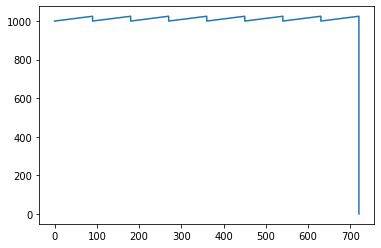

In [ ]:
# Без амортизации
EAD_test(1000, 10, 2, 3, amortization = False)

     terms     due  interest       EAD
0     0.00  1000.0     0.000  1000.000
90    0.25  1000.0    25.000  1025.000
180   0.25   875.0    21.875   896.875
270   0.25   750.0    18.750   768.750
360   0.25   625.0    15.625   640.625
450   0.25   500.0    12.500   512.500
540   0.25   375.0     9.375   384.375
630   0.25   250.0     6.250   256.250
720   0.25   125.0     3.125   128.125


array([0.  , 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25])

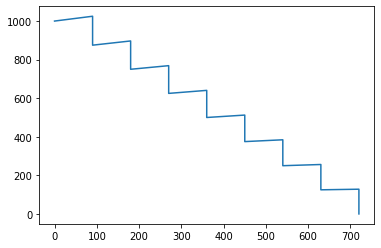

In [ ]:
# С амортизацией
EAD_test(1000, 10, 2, 3, amortization = True)

**Методология: EL**

1.  Для кредита генерируется ряд EAD (см. Методология EAD) и ряд PD
    (см. Методология PD)
2. Два ряда перемножаются, результат суммируется - математическое ожидание
    без учета LGD
3. Математическое ожидание LGD является константой - умножается на результат
    пункта 2.

In [ ]:
# Наследование от interpolate_PD_cum, чтобы удобно было брать методы для генерации вероятностей
def EAD(volume, interest, term, frequency, amortization):
    # Та же функция, что и выше
    schedule = np.array(range(0, (term)* 365, 30 * frequency))
    data = pd.DataFrame(np.nan, index = schedule, columns = ['terms', 'due', 'interest',  'EAD'])
    terms = np.zeros(len(schedule))
    terms[1:] = (schedule[1:] - schedule[:-1])/360
    if amortization:
        number_of_payments = int(term * 12 / frequency)
        main_payment = volume / number_of_payments
        payments_by_number = np.maximum(np.array(range(-1, number_of_payments)), 0)
        debt = volume - main_payment * payments_by_number
        interest_payment = np.zeros(len(debt))
        interest_payment = debt * (interest / 100) * terms
        EAD = debt + interest_payment
    else:
        debt = volume
        interest_payment = debt * (interest / 100) * terms
        EAD = debt + interest_payment
    return EAD
    
class EL(interpolate_PD_cum):
    def __init__(self, pd_matrix_marginal, rating_col):
        self.rating_col = rating_col
        super(EL, self).__init__(pd_matrix_marginal) # Инициализация класса intepolate_PD_cum с помощью матрицы маржинальных вероятностей
        self.find_pd_cum() # Заранее считаем кумулятивные вероятности
        self.find_hzrd_func() # И хазардные функции
        
    def calculate_EL(self, datapoint, rating_letter = "A"):
        amortization, term, volume, interest, frequency = (datapoint["Амортизация"], datapoint["Срок, лет"], datapoint["Объем"],
                                                                        datapoint["Процентная ставка, %"], datapoint["Частота выплат, месяцев"])
        term, frequency = int(term), int(frequency)
        rating = int(datapoint[self.rating_col].replace(rating_letter, "")) - 1
        
        # Получаем ряд EAD для конкретного кредита по дате
        ead_ = EAD(volume, interest, term, frequency, amortization)

        # Создание массива вероятностей для заданных term и frequency:
        dates = list(range(0, term * 365, 30 * frequency))
        prob_list = []
        # Создаем лист вероятностей дефолта для каждого периода EAD
        for i in dates:
            # Получаем вероятности в зависимости от даты
            prob = self.find_probability(i, rating)
            prob_list.append(prob)
        prob_list = np.array(prob_list)

        # Мат ожидание бета распределения
        lgd_expectation =  2 / (2 + 5)
        # Предполагаем, что на каждый период между выплатами EAD = max(EAD) за период
        simulations = ead_ * prob_list * lgd_expectation
        self.EL = simulations.sum()
        return self.EL


In [ ]:
df_filtered_A

,Клиент,Амортизация,"Срок, лет",Объем,"Процентная ставка, %","Частота выплат, месяцев",Рейтинг 1,Рейтинг 3,Вероятность A,Вероятность I
1,1,True,3,86833,2.95,1,A5,I3,0.054795,0.056604
2,2,False,5,1438492,4.51,12,A3,I2,0.019139,0.020243
3,3,False,4,1469169,4.30,1,A3,I4,0.019139,0.057971
4,4,True,2,630597,4.33,6,A4,I4,0.036585,0.057971
5,5,False,4,220186,5.77,12,A1,I2,0.017442,0.020243
...,...,...,...,...,...,...,...,...,...,...
795,795,True,2,69739,6.68,12,A5,I5,0.054795,0.074830
796,796,False,1,783667,6.04,12,A4,I3,0.036585,0.056604
797,797,True,5,671568,2.42,3,A5,I4,0.054795,0.057971
798,798,False,2,1357878,6.82,1,A4,I4,0.036585,0.057971


In [ ]:
marginal_matrix_A = rating_class_A.pd_matrix
el_calc = EL(marginal_matrix_A, rating_col = "Рейтинг 1")
df_filtered_A["EL"] = np.zeros(len(df_filtered_A))
# Генерация EL для каждого наблюдения в выборке
for i in range(len(df_filtered_A)):
    datapoint = df_filtered_A.iloc[i]
    df_filtered_A.iloc[i, 10] = el_calc.calculate_EL(datapoint, rating_letter= "A")

marginal_matrix_I = rating_class_I.pd_matrix
el_calc = EL(marginal_matrix_I, rating_col = "Рейтинг 1")
df_filtered_I["EL"] = np.zeros(len(df_filtered_I))
for i in range(len(df_filtered_I)):
    datapoint = df_filtered_I.iloc[i]
    df_filtered_I.iloc[i, 10] = el_calc.calculate_EL(datapoint, rating_letter= "A")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [ ]:
df_double_filtered_A = df_filtered_A[df_filtered_A["EL"] < 60000] # Фильтрация по EL
df_double_filtered_I = df_filtered_I[df_filtered_I["EL"] < 60000]

In [ ]:
df_double_filtered_A

,Клиент,Амортизация,"Срок, лет",Объем,"Процентная ставка, %","Частота выплат, месяцев",Рейтинг 1,Рейтинг 3,Вероятность A,Вероятность I,EL
1,1,True,3,86833,2.95,1,A5,I3,0.054795,0.056604,18068.128171
4,4,True,2,630597,4.33,6,A4,I4,0.036585,0.057971,41467.554723
5,5,False,4,220186,5.77,12,A1,I2,0.017442,0.020243,17480.468520
7,7,True,2,1480735,6.32,12,A3,I5,0.019139,0.074830,5610.725554
8,8,False,3,264565,6.02,6,A4,I6,0.036585,0.197802,56955.072498
...,...,...,...,...,...,...,...,...,...,...,...
792,792,False,1,294341,4.13,1,A3,I3,0.019139,0.056604,0.000000
793,793,False,5,54336,4.52,6,A4,I3,0.036585,0.056604,21304.554505
795,795,True,2,69739,6.68,12,A5,I5,0.054795,0.074830,1580.039546
796,796,False,1,783667,6.04,12,A4,I3,0.036585,0.056604,23434.236730


**Методология: VAR**
1. Для расчета VAR генерируются сценарии: 
    
2. Сценарий генерируется по формуле $X = \sqrt{ρ} Y + \sqrt{1 - ρ} ϵ \quad Y, ϵ \sim N(0, 1)$
    
3. $\rho$ зависит от вероятности и генерируется по формуле 
$0.12 \frac{1 - e^{50P}}{1 - e^{50}} + 0.24 (1 - \frac{1 - e^{50P}}{1 - e^{50}})$

4. X сравнивается со значением нормального распределения от вероятности дефолта в соответствующий момент времени. Если значение нормального распределения превосходит X - фиксируется дефолт

5. В каждой из 10000 генерации убираются все дефолты кроме первого

6. Ряд EAD умножается на ряд случайных значений LGD из $\beta$-распределения и на ряд индикаторов дефолта - получается распределение убытков

7. Для $VaR_{0.99}$ от распределения убытков берется 99% квантиль

In [ ]:
import scipy.stats as ss
import seaborn as sns
# Функция находит первое выполнение условия
# Нужно, чтобы дефолт в индикаторе был только 1 - следующие дефолты не входят в расчет EL
def find_first_condition(defaults_row):
    condition = np.where(defaults_row)
    if len(condition[0]) != 0:
        return condition[0][0]
    return None

def calc_rho(probs):
    # Рассчитывает rho в зависимости от вероятности дефолта 
    return 0.12 * (1 - np.exp(50 * probs)) / (1 - np.exp(50)) + 0.24 * (1 - ((1 - np.exp(50 * probs)) / (1 - np.exp(50))))

def default_simulation_for_i_firm(df_filtered, i, pd_matrix_marginal, 
                                  rating_letter = "A", rating_col = "Рейтинг 1"):
    # Схожий с генерацией EL процесс
    el = EL(pd_matrix_marginal, rating_col = rating_col)
    el.find_pd_cum()
    el.find_hzrd_func()
    datapoint = df_filtered.iloc[i]
    amortization, term, volume, interest, frequency, prob, rating = (datapoint["Амортизация"], 
                                                                     datapoint["Срок, лет"],
                                                                     datapoint["Объем"], 
                                                                     datapoint["Процентная ставка, %"],
                                                                     datapoint["Частота выплат, месяцев"],
                                                                     datapoint["Вероятность {}".format(rating_letter)],
                                                                     datapoint[rating_col])
    rating = int(rating.replace(rating_letter, "")) - 1
    term, frequency = int(term), int(frequency)
    dates = list(range(0, term * 365, 30 * frequency))
    prob = []
    for i in dates:
        # Получаем вероятности в зависимости от даты
        prob_i = el.find_probability(i, rating)
        prob.append(prob_i)
    prob = np.array(prob)
    # Считаем rho от листа вероятностей
    rho = calc_rho(prob) 

    ead = EAD(volume, interest, term, frequency, amortization)
    # Создаем для каждого заемщика случайное распределение состояний экономики на протяжении займа
    Y = np.random.normal(0, 1, [10000, len(ead)])
    e = np.random.normal(0, 1, [10000, len(ead)])
    X = np.sqrt(rho)*Y + np.sqrt(1 - rho)*e
    DB = ss.norm.ppf(prob)
    defaults = X < DB
    default_index = np.zeros((10000, len(ead)))

    lgd = np.random.beta(a = 2, b = 5, size = (len(ead), ))
    # Находим первый момент дефолта в каждой симуляции
    for i in range(len(defaults)):
        condition = find_first_condition(defaults[i])
        if condition != None:
            default_index[i, condition] = 1
    # Умножаем индикатор дефолта на ряд EAD, чтобы получить EAD в момент дефолта
    loss = default_index @ (ead * lgd)
    return loss

def generate_defaults(df_filtered, pd_matrix, 
                      rating_letter = "A", rating_col = "Рейтинг 1"):
    default_simulation_matrix = np.zeros((len(df_filtered), 10000))
    # Генерируем дефолты для каждого заемщика
    for i in range(len(df_filtered)):
        default_simulation_matrix[i] = default_simulation_for_i_firm(df_filtered, i, pd_matrix, 
                                                                     rating_letter, rating_col)
    return default_simulation_matrix

In [ ]:
pd_matrix_A = rating_class_A.pd_matrix
pd_matrix_I = rating_class_I.pd_matrix
default_matrix_A = generate_defaults(df_double_filtered_A, pd_matrix_A, 
                                     rating_letter = "A", rating_col = "Рейтинг 1")
default_matrix_I = generate_defaults(df_double_filtered_I, pd_matrix_I,
                                     rating_letter = "I", rating_col = "Рейтинг 3")

In [ ]:
def get_mean_EAD(df):
    ead_array = np.zeros((100, ))
    for i in range(len(df)):
        datapoint = df.iloc[i]
        amortization, term, volume, interest, frequency = (datapoint["Амортизация"], datapoint["Срок, лет"], datapoint["Объем"],
                                                                        datapoint["Процентная ставка, %"], datapoint["Частота выплат, месяцев"])
        # Растягиваем EAD с низкой частотностью, чтобы для всех EAD было 12 состояний
        datapoint_ead = np.repeat(EAD(volume, interest, term, frequency, amortization), frequency)

        # Паддинг для того, чтобы более длинные кредиты влезали в array
        datapoint_pad = np.zeros((100, ))
        datapoint_pad[:datapoint_ead.shape[0], ] = datapoint_ead
        ead_array += datapoint_pad
    return ead_array / len(df)

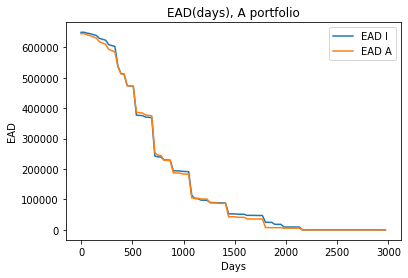

In [ ]:
mean_EAD_A = get_mean_EAD(df_double_filtered_A)
mean_EAD_I = get_mean_EAD(df_double_filtered_I)
dates = [i * 30 for i in range(100)]
plt.plot(dates, mean_EAD_I,label='EAD I')
plt.plot(dates, mean_EAD_A,label='EAD A')
plt.xlabel("Days")
plt.ylabel("EAD")
plt.title("EAD(days), A portfolio")
plt.legend()

Экспозиции двух портфелей практически идентичны, но у портфеля она А чуть меньше. Самое большое падение в EAD случается после примерно второго года. EL снижается со временем, что может указывать на большую долю амортизируемых кредитов. Основные снижения EL происходят в годовых промежутках

Text(0.5, 1.0, 'Гистограмма рейтинга I в портфеле заемщиков, выбранных по I')

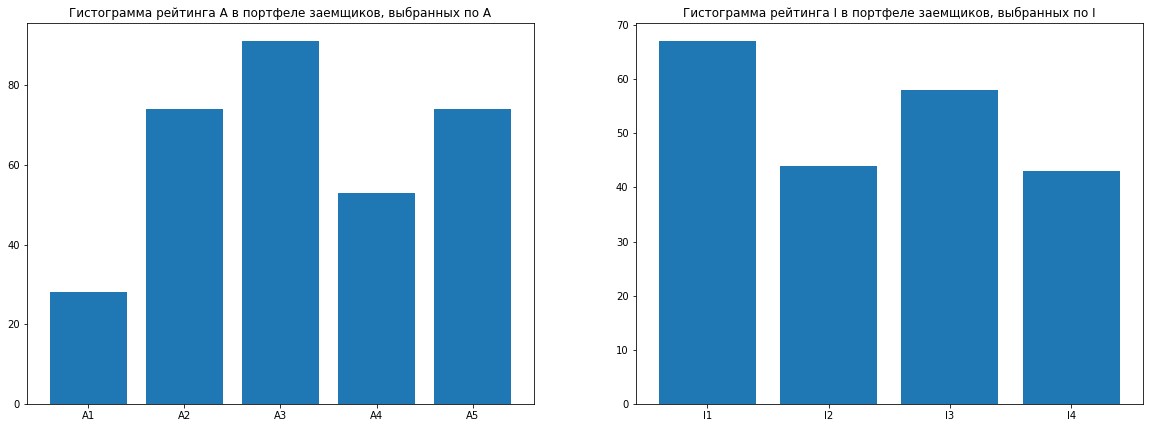

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 7))
ax[0].bar(df_double_filtered_A.groupby("Рейтинг 1").sum().index, df_double_filtered_A.groupby('Рейтинг 1')['Клиент'].count())
ax[0].set_title("Гистограмма рейтинга A в портфеле заемщиков, выбранных по A")
ax[1].bar(df_double_filtered_I.groupby("Рейтинг 3").sum().index, df_double_filtered_I.groupby('Рейтинг 3')['Клиент'].count())
ax[1].set_title("Гистограмма рейтинга I в портфеле заемщиков, выбранных по I")

Количество кредитов в каждом рейтинге примерно одинаково, кроме рейтинга А1.

Text(0.5, 1.0, 'Гистограмма объема в портфеле заемщиков, выбранных по I')

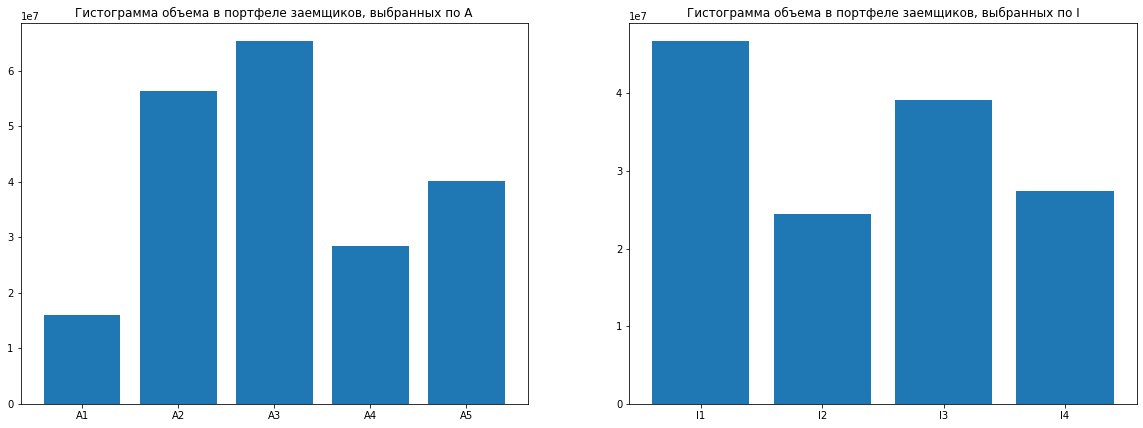

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 7))
ax[0].bar(df_double_filtered_A.groupby("Рейтинг 1").sum().index, df_double_filtered_A.groupby("Рейтинг 1").sum()['Объем'].values)
ax[0].set_title("Гистограмма объема в портфеле заемщиков, выбранных по A")
ax[1].bar(df_double_filtered_I.groupby("Рейтинг 3").sum().index, df_double_filtered_I.groupby("Рейтинг 3").sum()['Объем'].values)
ax[1].set_title("Гистограмма объема в портфеле заемщиков, выбранных по I")

**Методология: UL**

$UL = VaR_{0.99} - EL$

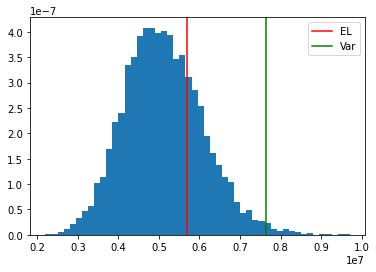

VaR_A: 7636730.59 

EL_A: 5696450.35
   EL_A %: 2.76 

UL_A: 1940280.24
   UL_A %: 0.9400000000000001


In [ ]:
portfolio_A_EL = df_double_filtered_A["EL"].sum()
portfolio_A_Var = np.quantile(default_matrix_A.sum(axis = 0), q = 0.99,
                              interpolation = "lower")
plt.hist(default_matrix_A.sum(axis = 0), density = True, bins = 50)
plt.axvline(x = portfolio_A_EL, color = "r", label = "EL")
plt.axvline(x = portfolio_A_Var, color = "green", label = "Var")
plt.legend()
plt.show()
UL_A = portfolio_A_Var - portfolio_A_EL
print("VaR_A:", round(portfolio_A_Var, 2), '\n')
print("EL_A:", round(portfolio_A_EL, 2))
print("   EL_A %:", round(portfolio_A_EL / df_double_filtered_A["Объем"].sum(), 4) * 100, '\n')
print("UL_A:", round(UL_A, 2))
print("   UL_A %:", round(UL_A / df_double_filtered_A["Объем"].sum(), 4) * 100)

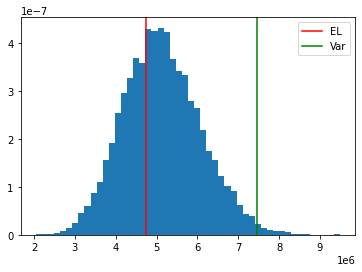

VaR_I: 7460458.98 

EL_I: 4736558.3
   EL_I %: 3.44 

UL_I: 2723900.67
   UL_I %: 1.9800000000000002


In [ ]:
portfolio_I_EL = df_double_filtered_I["EL"].sum(axis = 0)
portfolio_I_Var = np.quantile(default_matrix_I.sum(axis = 0), q = 0.99,
                              interpolation = "lower")
UL_I = portfolio_I_Var - portfolio_I_EL
plt.hist(default_matrix_I.sum(axis = 0), density = True, bins = 50)
plt.axvline(x = portfolio_I_EL, color = "r", label = "EL")
plt.axvline(x = portfolio_I_Var, color = "green", label = "Var")
plt.legend()
plt.show()
print("VaR_I:", round(portfolio_I_Var, 2), '\n')
print("EL_I:", round(portfolio_I_EL, 2))
print("   EL_I %:", round(portfolio_I_EL / df_double_filtered_I["Объем"].sum(), 4) * 100, '\n')
print("UL_I:", round(UL_I, 2))
print("   UL_I %:", round(UL_I / df_double_filtered_I["Объем"].sum(), 4) * 100)

Var_I ниже Var_A на 112 тыс. руб., что делает портфель I менее рискованным в абсолютных значениях. Тем не менее, ожидаемые потери портфеля I немного выше ожидаемых потерь А в процентном отношении к портфелю, это справедливо и для непредсказуемых потерь. 
Большим недостатком портфеля I является то, что его непредвиденные потери более чем в два раза превышают непредвидимые потери портфеля А. В целом, портфель А выходит менее рискованным.